# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json

from scipy.stats import linregress
from citipy import citipy
from pprint import pprint

from api_keys import weather_api_key
from api_keys import g_key

# Set output file path
output_file = "../output_files/cities_weather.csv"

# Set range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# Creat empty lists for lat_lgn and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Find the closest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
# If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

print(f"There's %s cities to poll for weather." % len(cities))

There's 603 cities to poll for weather.


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Setup Query URL
base_url = "http://api.openweathermap.org/data/2.5/weather?appid="
api_key = weather_api_key
units = "imperial"
query_url = f"{base_url}{api_key}&units={units}&q="

In [4]:
# Create dictionary to store data from API calls
city_weather_data = {"City": [],
                     "Lat": [],
                     "Lng": [],
                     "Max Temp": [],
                     "Humidity": [],
                     "Cloudiness": [],
                     "Wind Speed": [],
                     "Country": [],
                     "Date": []}

# Loop thru the API call data to add the data retrieved into the dictionary
for i, city in enumerate(cities):
    city = requests.get(query_url + cities[i].replace(" ","&")).json()

    try:
        print(f"Processing city " + str(i) + ": " + city["name"])

        city_weather_data["City"].append(city["name"])
        city_weather_data["Lat"].append(city["coord"]["lat"])
        city_weather_data["Lng"].append(city["coord"]["lon"])
        city_weather_data["Max Temp"].append(city["main"]["temp_max"])
        city_weather_data["Humidity"].append(city["main"]["humidity"])
        city_weather_data["Cloudiness"].append(city["clouds"]["all"])
        city_weather_data["Wind Speed"].append(city["wind"]["speed"])
        city_weather_data["Country"].append(city["sys"]["country"])
        city_weather_data["Date"].append(city["dt"])

    except:
        print(f"Data retrieve failure. Skipping city instance...")
        pass
print("Data retrieval is completed.")

Processing city 0: Pevek
Processing city 1: Hong Kong
Processing city 2: Mar
Processing city 3: Nanortalik
Processing city 4: Mochudi
Processing city 5: Balakhninskiy
Processing city 6: Qaanaaq
Processing city 7: El Puerto de Santa María
Processing city 8: Soe
Processing city 9: Ribeira
Processing city 10: Vaini
Data retrieve failure. Skipping city instance...
Processing city 12: Port
Processing city 13: Nador
Processing city 14: Atuona
Processing city 15: Norman
Processing city 16: Rikitea
Processing city 17: Geraldton
Processing city 18: Bandarbeyla
Processing city 19: Ushuaia
Processing city 20: Raudeberg
Processing city 21: Saskylakh
Processing city 22: Tshikapa
Processing city 23: Thompson
Processing city 24: Harper
Processing city 25: Pacific
Processing city 26: Port
Processing city 27: Zhangye
Processing city 28: Airai
Processing city 29: Saldanha
Processing city 30: Provideniya
Processing city 31: Bara
Data retrieve failure. Skipping city instance...
Processing city 33: Coquimb

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Export the city data into CSV
city_weather_df = pd.DataFrame(city_weather_data)
city_weather_df.to_csv(output_file, index = False)

# Display DataFrame
print(city_weather_df.head())

# Count the number of cities with data that were successfully pulled from API call
city_retrieved = city_weather_df["City"].count()
print(f"There's %s cities data retrieved out of {len(cities)} cities." % city_retrieved)

# Calculate successful rate
success_rate = round((city_retrieved / len(cities) * 100),2)
print(f"Success rate is: %s" % success_rate  + "%.")

         City      Lat       Lng  Max Temp  Humidity  Cloudiness  Wind Speed  \
0       Pevek  69.7008  170.3133     27.52        79          61       14.92   
1   Hong Kong  22.2855  114.1577     90.97        82          37        1.01   
2         Mar  43.4002   -4.0094     85.84        72           0        6.91   
3  Nanortalik  60.1432  -45.2371     44.06        81         100       13.09   
4     Mochudi -24.4167   26.1500     75.79        15           0        8.75   

  Country        Date  
0      RU  1631359842  
1      HK  1631359843  
2      ES  1631359844  
3      GL  1631359845  
4      BW  1631359845  
There's 543 cities data retrieved out of 603 cities.
Success rate is: 90.05%.


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
# Test to make sure no city has humdity over 100%
test_stats = city_weather_df["Humidity"].describe()
print(test_stats)
print(f"Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.")

count    543.000000
mean      67.742173
std       21.843536
min        7.000000
25%       55.000000
50%       71.000000
75%       85.000000
max      100.000000
Name: Humidity, dtype: float64
Inspection result showing the maximum humidity value is 100%. Number of cities to analyze remains the same.


In [7]:
#  Get the indices of cities that have humidity over 100%.

In [8]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [9]:
# Creates variables for relevant table columns
lat = city_weather_df["Lat"]
max_temp = city_weather_df["Max Temp"]
humidity = city_weather_df["Humidity"]
cloudiness = city_weather_df["Cloudiness"]
wind_speed = city_weather_df["Wind Speed"]

## Latitude vs. Temperature Plot

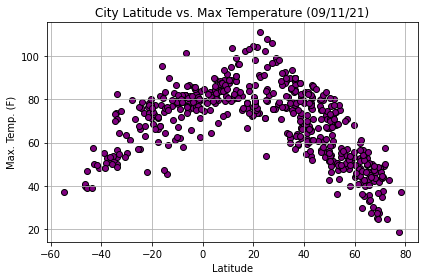

In [37]:
# Plotting data into graph
plt.scatter(lat, max_temp, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Max. Temp. (F)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Temp.png")


## Latitude vs. Humidity Plot

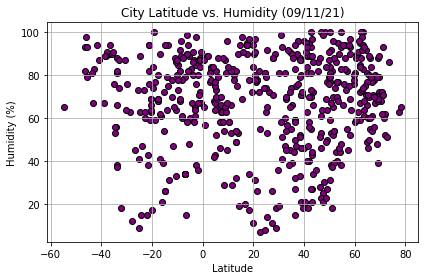

In [11]:
# Plotting data into graph
plt.scatter(lat, humidity, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Humidity (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Humid.png")

## Latitude vs. Cloudiness Plot

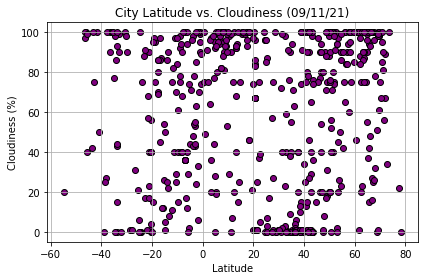

In [12]:
# Plotting data into graph
plt.scatter(lat, cloudiness, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Cloudiness (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Cloud.png")

## Latitude vs. Wind Speed Plot

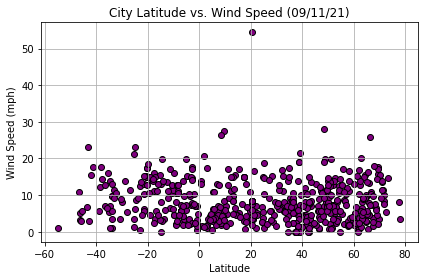

In [35]:
# Plotting data into graph
plt.scatter(lat, wind_speed, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")

plt.title("City Latitude vs. Wind Speed (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid(True)
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/Lat_Wind.png")

## Linear Regression

# Define plotting function
def plot_linear_regression(xdata, ydata, xlbl, ylbl, lblpos):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xdata, ydata)
    print(f"The r-squared is: {rvalue}")
    regress_values = xdata * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

    plt.scatter(xdata, ydata, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
    plt.plot(xdata,regress_values, "orange")
    plt.annotate(line_eq, lblpos, fontsize = 15, color = "orange")
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)

In [14]:
# Create Northern Hemisphere DataFrames
northern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] >= 0.0]
northern_hemisphere.reset_index(inplace = True)

# Create Southern Hemisphere DataFrames
southern_hemisphere = city_weather_df.loc[city_weather_df["Lat"] < 0.0]
southern_hemisphere.reset_index(inplace = True)

print(northern_hemisphere.head())
print(southern_hemisphere.head())

   index           City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      0          Pevek  69.7008  170.3133     27.52        79          61   
1      1      Hong Kong  22.2855  114.1577     90.97        82          37   
2      2            Mar  43.4002   -4.0094     85.84        72           0   
3      3     Nanortalik  60.1432  -45.2371     44.06        81         100   
4      5  Balakhninskiy  58.0106  114.2769     52.90        90         100   

   Wind Speed Country        Date  
0       14.92      RU  1631359842  
1        1.01      HK  1631359843  
2        6.91      ES  1631359844  
3       13.09      GL  1631359845  
4        1.54      RU  1631359846  
   index     City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0      4  Mochudi -24.4167   26.1500     75.79        15           0   
1      8      Soe  -9.8607  124.2840     67.14        85          61   
2     10    Vaini -21.2000 -175.2000     71.76        94          90   
3     11     Port  -7.0349 

In [15]:
# Create variables for relevant table columns
nlat = northern_hemisphere["Lat"]
nmax_temp = northern_hemisphere["Max Temp"]
nhumidity = northern_hemisphere["Humidity"]
ncloudiness = northern_hemisphere["Cloudiness"]
nwind_speed = northern_hemisphere["Wind Speed"]

slat = southern_hemisphere["Lat"]
smax_temp = southern_hemisphere["Max Temp"]
shumidity = southern_hemisphere["Humidity"]
scloudiness = southern_hemisphere["Cloudiness"]
swind_speed = southern_hemisphere["Wind Speed"]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

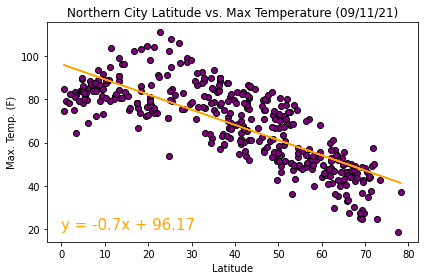

In [16]:
# Create Scatter Plot for Northern Hemisphere - Max Temp vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(nlat, nmax_temp)
regress_values = nlat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nlat, nmax_temp, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Northern City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.plot(nlat, regress_values, "orange")
plt.annotate(line_eq, (0, 20), fontsize = 15, color = "orange")

plt.ylabel("Max. Temp. (F)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/NLat_Temp.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

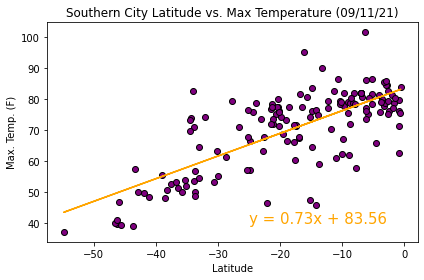

In [17]:
# Create Scatter Plot for Southern Hemisphere - Max Temp vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(slat, smax_temp)
regress_values = slat * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(slat, smax_temp, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Southern City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.plot(slat, regress_values, "orange")
plt.annotate(line_eq, (-25, 40),fontsize = 15, color="orange")

plt.ylabel("Max. Temp. (F)")
plt.xlabel("Latitude")
plt.tight_layout()

plt.savefig("../output_files/SLat_Temp.png")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

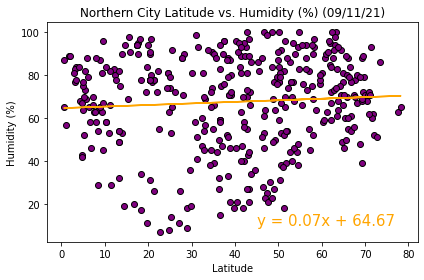

In [21]:
# Create Scatter Plot for Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(nlat, nhumidity)
regress_values = nlat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nlat, nhumidity, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Northern City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x"))
plt.plot(nlat, regress_values, "orange")
plt.annotate(line_eq, (45, 10), fontsize = 15, color = "orange")

plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/NLat_Humid.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

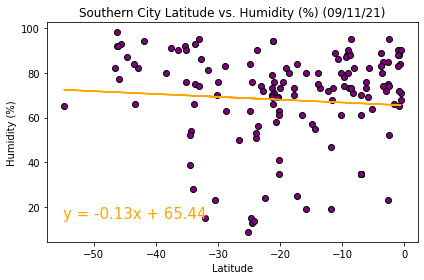

In [ ]:
# Create Scatter Plot for Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(slat, shumidity)
regress_values = slat * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(slat, shumidity, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Southern City Latitude vs. Humidity (%%) (%s)" % time.strftime("%x"))
plt.plot(slat, regress_values, "orange")
plt.annotate(line_eq, (-55, 15),fontsize = 15, color="orange")

plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save grpah as PNG
plt.savefig("../output_files/SLat_Humid.png")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

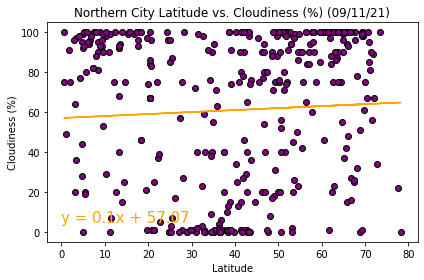

In [27]:
# Create Scatter Plot for Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(nlat, ncloudiness)
regress_values = nlat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nlat, ncloudiness, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Northern City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x"))
plt.plot(nlat, regress_values, "orange")
plt.annotate(line_eq, (0, 5), fontsize = 15, color = "orange")

plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/NLat_Cloud.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

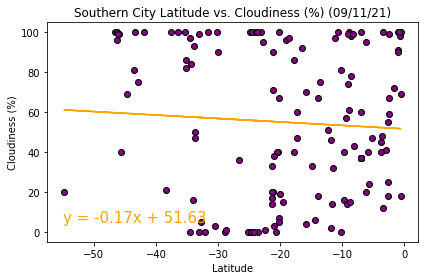

In [ ]:
# Create Scatter Plot for Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(slat, scloudiness)
regress_values = slat * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(slat, scloudiness, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Southern City Latitude vs. Cloudiness (%%) (%s)" % time.strftime("%x"))
plt.plot(slat, regress_values, "orange")
plt.annotate(line_eq, (-55, 5),fontsize = 15, color="orange")

plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/SLat_Cloud.png")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

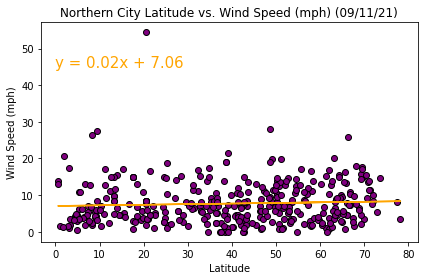

In [34]:
# Create Scatter Plot for Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(nlat, nwind_speed)
regress_values = nlat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nlat, nwind_speed, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Northern City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x"))
plt.plot(nlat, regress_values, "orange")
plt.annotate(line_eq, (0, 45), fontsize = 15, color = "orange")

plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/NLat_Wind.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

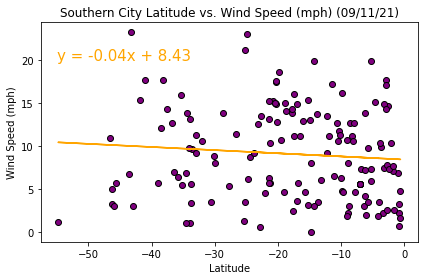

In [33]:
# Create Scatter Plot for Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(slat, swind_speed)
regress_values = slat * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(slat, swind_speed, linewidths = 1, marker = "o", edgecolors = "black", color = "purple")
plt.title("Southern City Latitude vs. Wind Speed (mph) (%s)" % time.strftime("%x"))
plt.plot(slat, regress_values, "orange")
plt.annotate(line_eq, (-55, 20), fontsize = 15, color="orange")

plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.tight_layout()

# Save graph as PNG
plt.savefig("../output_files/SLat_Wind.png")